### Creating a test file from the inference test:

In [32]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
from tqdm import tqdm

import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR import NPI, setup, file_paths, parameters,compartments
from SEIR.utils import config
import pathlib
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import subprocess
import Outcomes.outcomes as outcomes
#import multiprocessing as mp
#pool = mp.Pool(mp.cpu_count())

In [2]:
outdir = 's3pull/'
mask10 = '00000001'   # So we just do
all_runs = {'R5_highVac_modNPI_npiredux':{
                'bucket':  's3://idd-inference-runs/USA-20210513T031236/model_output/',
                'config':  '../COVID19_USA/config_smh_R5_highVac_modNPI_npiredux.yml',
                'geodata': '../COVID19_USA/'},
            'R5_lowVac_lowNPI_npiredux':{
                'bucket':  's3://idd-inference-runs/USA-20210513T162809/model_output/',
                'config':  '../COVID19_USA/config_smh_R5_lowVac_lowNPI_npiredux.yml',
                'geodata': '../COVID19_USA/'}
}

In [5]:
for run_name, run_spec in all_runs.items():
    print(f'pulling {run_name}')
    command = f"""aws s3 sync {run_spec['bucket']} {outdir}{run_name}/ --exclude "*" --include "*/global/final/{mask10}*" """
    print(f'{command}')
    result = subprocess.run(command, stdout=subprocess.PIPE, shell=True)

pulling R5_highVac_modNPI_npiredux
aws s3 sync s3://idd-inference-runs/USA-20210513T031236/model_output/ s3pull/R5_highVac_modNPI_npiredux/ --exclude "*" --include "*/global/final/00000001*" 
pulling R5_lowVac_lowNPI_npiredux
aws s3 sync s3://idd-inference-runs/USA-20210513T162809/model_output/ s3pull/R5_lowVac_lowNPI_npiredux/ --exclude "*" --include "*/global/final/00000001*" 


In [33]:
outdir = 's3pull/'
all_runs = {
           # 'bad':'state-runs/bad/USA/inference/med/2021.01.12.16:31:54./global/intermediate/',
           # 'good':'state-runs/good/USA/inference/med/2021.01.08.06:30:35./global/intermediate/',
            #'R10_OLD':'s3pull/R10/llik/USA/inference/med/R10_optWan_highBooCA-FL-MD-MN-WA/global/intermediate/',
            'R10_full_fix':'s3pull/R10_full_fix/llik/USA/inference/med/R10_optWan_highBooCA-FL-MD-MN-WA/global/intermediate/',
    'R10_seasOnly':'s3pull/R10_seasOnly/llik/USA/inference/med/R10_optWan_highBoo_SeasOnly_CA-FL-MD-MN-WA/global/intermediate/',
  #  'R10_wild_only':'s3pull/R10_wild_only/llik/USA/inference/med/R10_optWan_highBoo_WildOnly_CA-FL-MD-MN-WA/global/intermediate/'
           }

In [36]:
all_runs = {'R10_fullfix':{
                'config': '../COVID19_USA/config_SMH_R10_optWan_highBooCA-FL-MD-MN-WA.yml',
                'geodata': '../COVID19_USA/'},
            'R10_seasonly':{
                'config': '../COVID19_USA/config_SMH_R10_optWan_highBoo_SeasOnly_CA-FL-MD-MN-WA.yml',
                'geodata': '../COVID19_USA/'},
            
}

In [40]:
print('analyzing Transmission')
betas = {}
r0s = {}
diffIs = {}
incidProbs = {}
for run_name, run_spec in all_runs.items():
    config.clear()
    config.read(user=False)
    config.set_file(run_spec['config'])
    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(run_spec['geodata'] + spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True
    npi_df = []

    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        parameters_config=config["seir"]["parameters"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix,
        config_version = 'v2'
    )

    #folder = [x for x in Path(f'{outdir}{run_name}/snpi/').glob('**') if not x.is_file()]
    
    folder = [x for x in Path(f'{outdir}{run_name}/seir/').glob('**') if not x.is_file()]
    folder.reverse()
    folder = folder[1]

    betas[run_name] = []
    r0s[run_name] = []
    diffIs[run_name] = []
    
    maxfiles = 30

    print(f'Exploring {str(folder)[:]} ... ', end = '')
    files_loaded = 0
    for snpi_fn in Path(str(folder)).rglob('*.parquet'):
        snpi_fn = str(snpi_fn)
        if (('chimeric' not in snpi_fn) and (files_loaded < maxfiles) and ('final' in snpi_fn)):
            slot = int(snpi_fn.split('/')[-1].split('.')[0])
            sim = snpi_fn.split('/')[-1].split('.')[1]
            print(slot, sim)
            #hpar =  pq.read_table(hpar_fn).to_pandas()
            #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
            #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
            #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
            seirf = pq.read_table(snpi_fn.replace('snpi', 'seir')).to_pandas()
            diffIs[run_name].append(seirf)
            if False:

                snpi = pq.read_table(snpi_fn).to_pandas()
                npi = NPI.NPIBase.execute(
                    npi_config=s.npi_config,
                    global_config=config,
                    geoids=s.spatset.nodenames
                    #,loaded_df = snpi
                )
                p_draw = s.parameters.parameters_load(snpi_fn.replace('snpi', 'spar')[:-8],
                    s.n_days,
                    s.nnodes)

                parameters = s.parameters.parameters_reduce(p_draw, npi)
                betas[run_name].append(npi.getReduction('r0').T)#['06000']#.mean(axis=1) #
                r0s[run_name].append(parameters[1])

            files_loaded += 1

    print(files_loaded, 'files read')

analyzing Transmission
Exploring s3pull/R10_fullfix/seir/USA/inference/med/R10_optWan_highBooCA-FL-MD-MN-WA/global/final ... 193 R10_optWan_highBooCA-FL-MD-MN-WA
225 R10_optWan_highBooCA-FL-MD-MN-WA
61 R10_optWan_highBooCA-FL-MD-MN-WA
143 R10_optWan_highBooCA-FL-MD-MN-WA
112 R10_optWan_highBooCA-FL-MD-MN-WA
30 R10_optWan_highBooCA-FL-MD-MN-WA
274 R10_optWan_highBooCA-FL-MD-MN-WA
278 R10_optWan_highBooCA-FL-MD-MN-WA
42 R10_optWan_highBooCA-FL-MD-MN-WA
160 R10_optWan_highBooCA-FL-MD-MN-WA
206 R10_optWan_highBooCA-FL-MD-MN-WA
92 R10_optWan_highBooCA-FL-MD-MN-WA
287 R10_optWan_highBooCA-FL-MD-MN-WA
257 R10_optWan_highBooCA-FL-MD-MN-WA
131 R10_optWan_highBooCA-FL-MD-MN-WA
229 R10_optWan_highBooCA-FL-MD-MN-WA
13 R10_optWan_highBooCA-FL-MD-MN-WA
184 R10_optWan_highBooCA-FL-MD-MN-WA
154 R10_optWan_highBooCA-FL-MD-MN-WA
76 R10_optWan_highBooCA-FL-MD-MN-WA
232 R10_optWan_highBooCA-FL-MD-MN-WA
8 R10_optWan_highBooCA-FL-MD-MN-WA
263 R10_optWan_highBooCA-FL-MD-MN-WA
59 R10_optWan_highBooCA-FL-MD-MN

In [38]:

folder

[]

In [13]:
s.parameters.get_pnames2pindex()

{'sigma': 0,
 'alpha': 1,
 'r0': 2,
 'gamma': 3,
 'theta1_WILD': 4,
 'theta2_WILD': 5,
 'theta1_ALPHA': 6,
 'theta2_ALPHA': 7,
 'theta1_DELTA': 8,
 'theta2_DELTA': 9,
 'thetaW_age0to17': 10,
 'thetaW_age18to64': 11,
 'thetaW_age65to100': 12,
 'nu1age0to17': 13,
 'nu1age18to64': 14,
 'nu1age65to100': 15,
 'nu2': 16,
 'chi1': 17,
 'chi2': 18,
 'epsilon': 19}

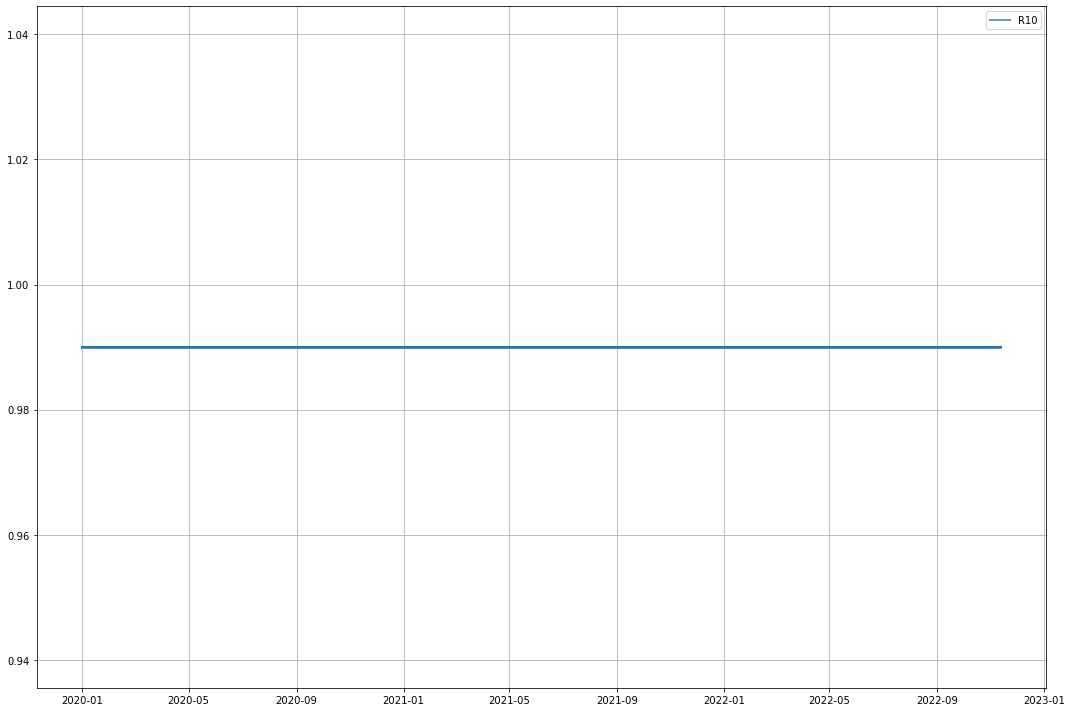

In [23]:
fig, axes = plt.subplots(1,1, figsize = (15,10))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
ax = axes
i = 0
for run_name, run_spec in all_runs.items():
    label = run_name
    for sim, ts in enumerate(r0s[run_name]):
        a = pd.DataFrame(index = pd.date_range(s.ti, s.tf), data = ts.mean(axis=1))
        ax.plot(a, colors[i],  ls='-', alpha=0.7, label = label, lw=2) # lw = int(sim),
        label = '_'
       
       # ax.set_yscale('log')
    i+=1
fig.tight_layout()
fig.set_facecolor('white')
ax.legend()
ax.grid()
#ax.set_xlim('2021-05-01','2021-11-01')
#ax.set_ylim(0.4,0.6)

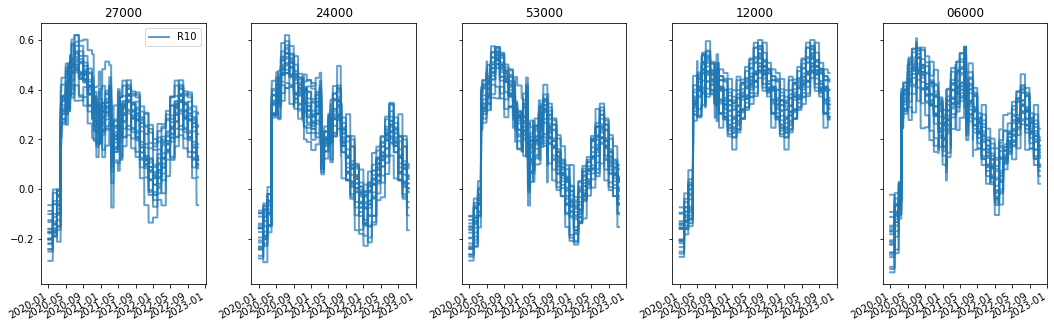

In [31]:
fig, ax = plt.subplots(1,5, figsize = (15,5), sharex = True, sharey=True)
fig.set_facecolor('white')
#colors = ['r', 'b']
j = 0

for name, dc in all_runs.items():
    k=0
    for sim, ts in enumerate(betas[name]):
        for i, nd in enumerate(s.spatset.nodenames):
            if  k == 0:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2, label = name)
                k = 1
            else:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2)
            ax.flat[i].set_title(nd)
            ax.flat[i].grid()
                
    j += 1
ax.flat[0].legend()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('seir_npi.pdf')

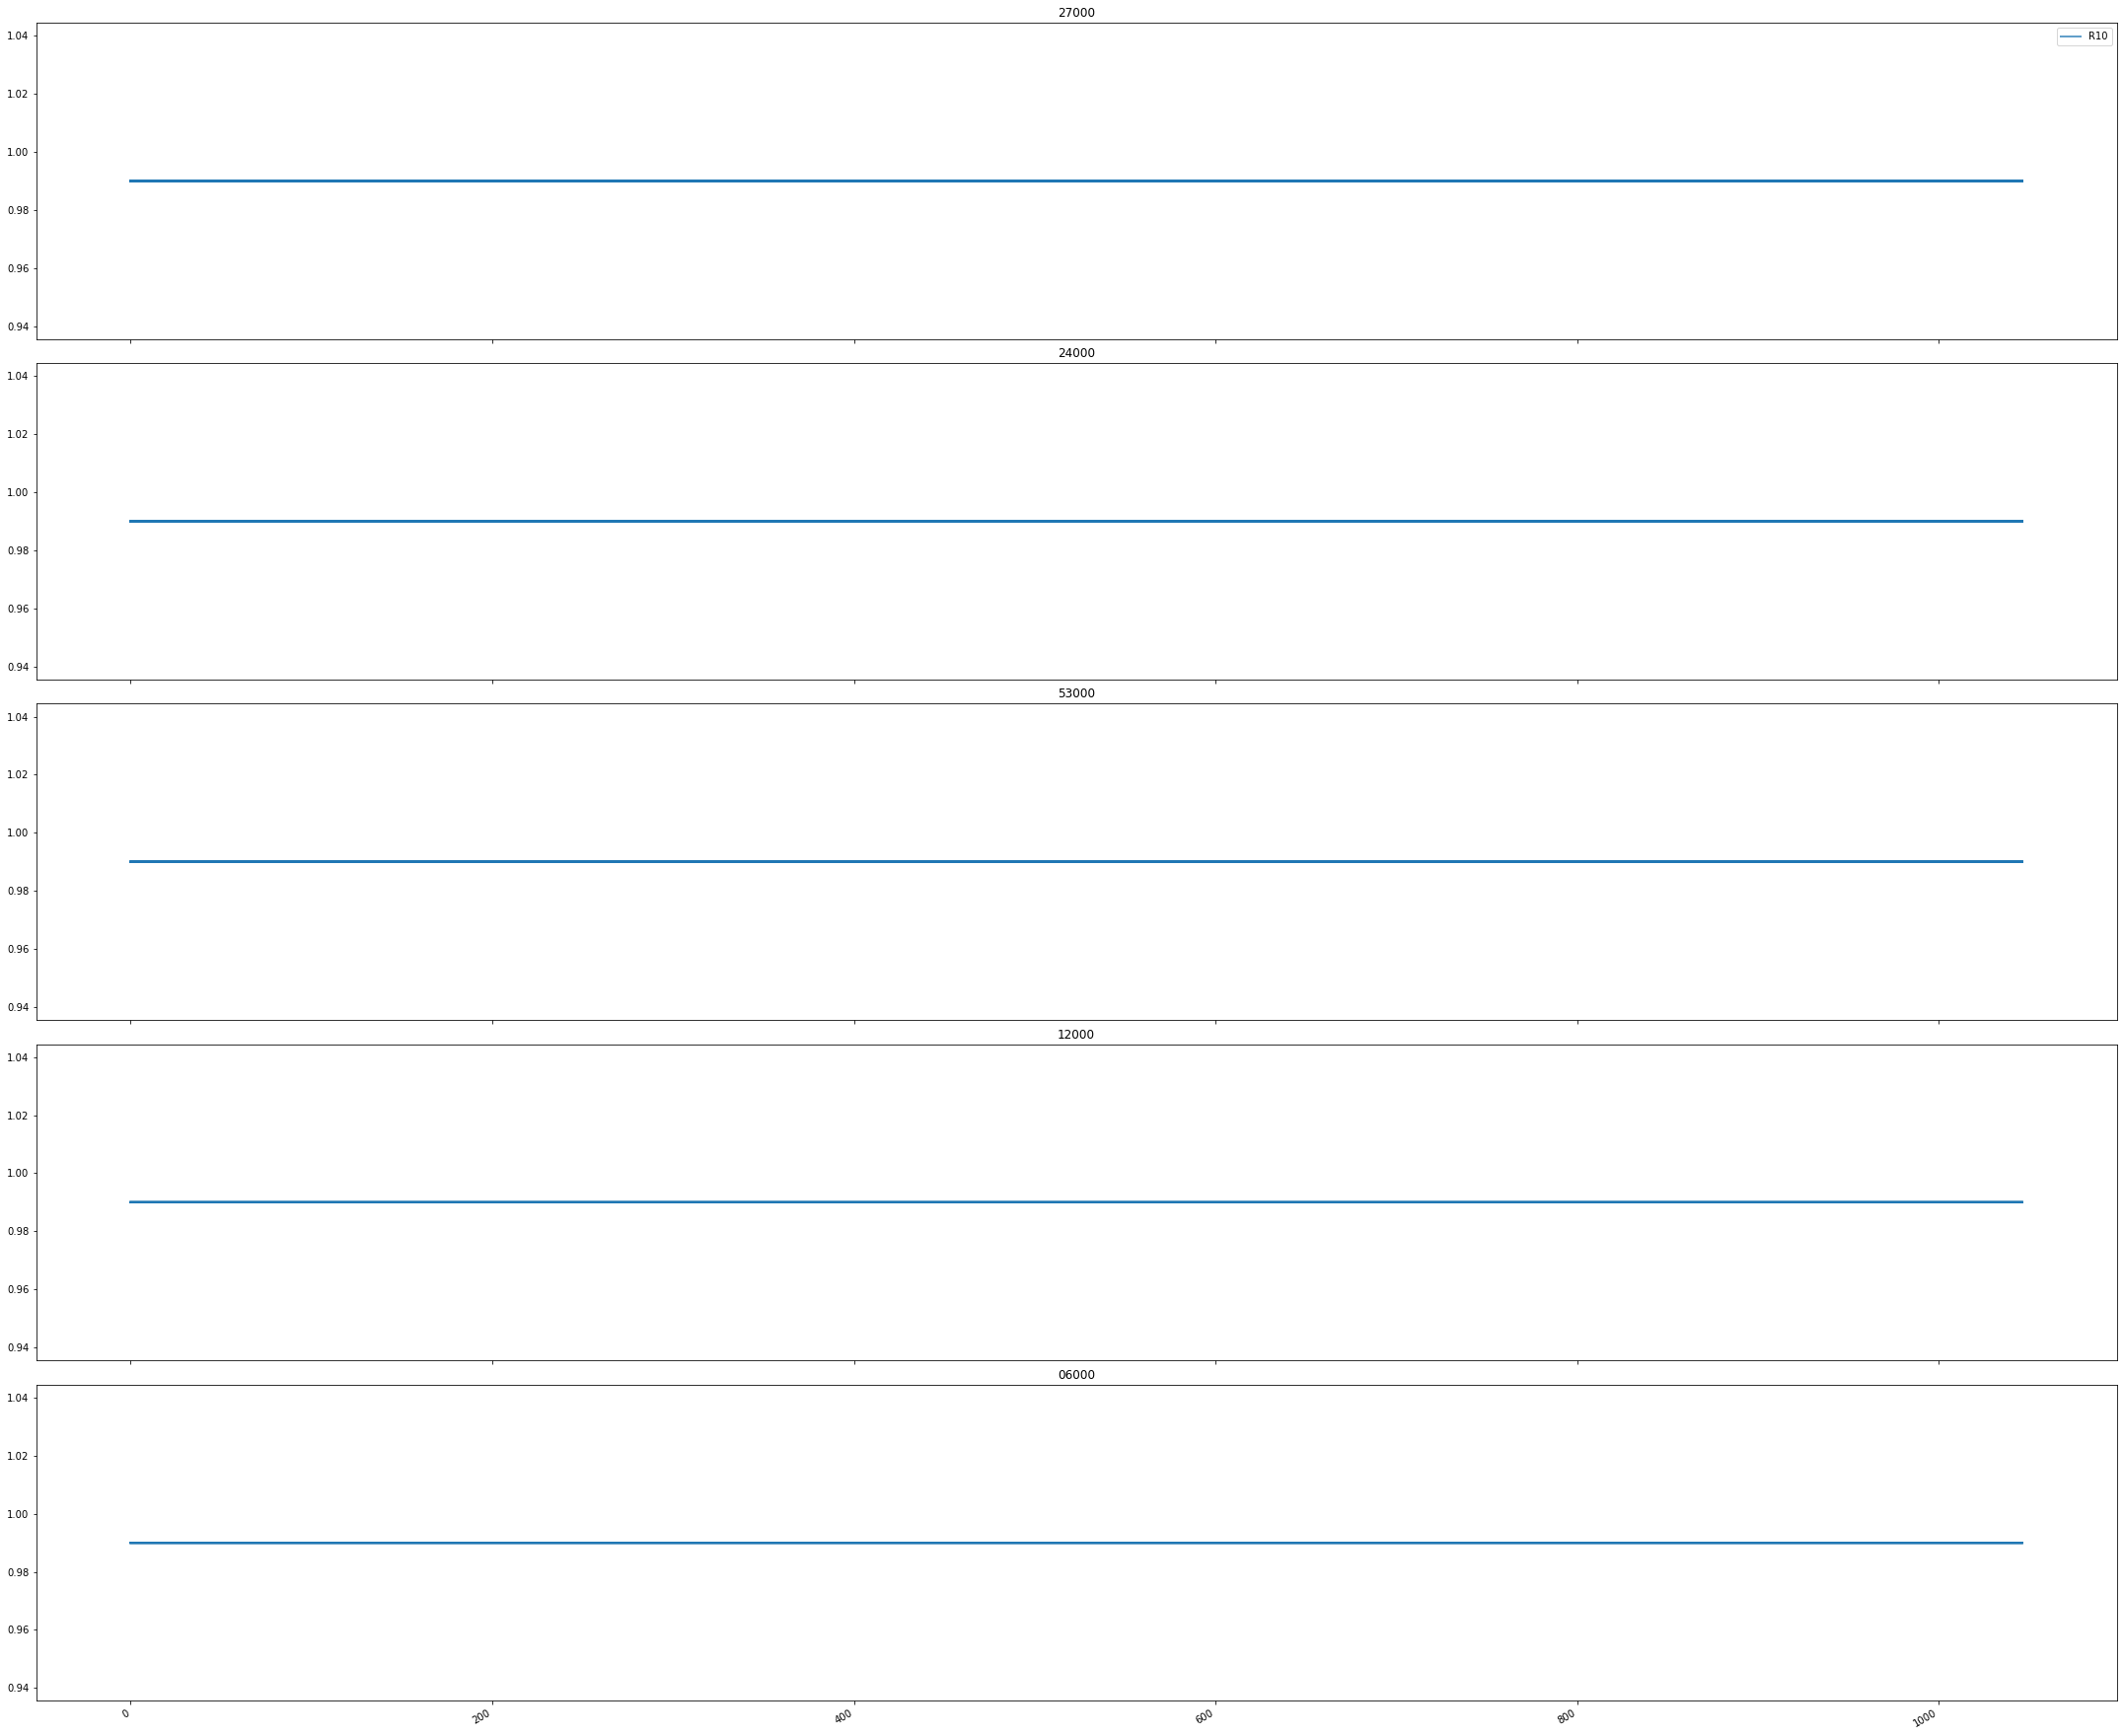

In [25]:
fig, ax = plt.subplots(5,1, figsize = (30,30), sharex = True, sharey=True)
fig.set_facecolor('white')
#colors = ['r', 'b']
j = 0

for name, dc in all_runs.items():
    k=0
    for sim, ts in enumerate(r0s[name]):
        for i, nd in enumerate(s.spatset.nodenames):
            if  k == 0:
                ax.flat[i].plot(ts.T[i], color = colors[j], alpha = .7, lw = 2, label = name)
                k = 1
            else:
                ax.flat[i].plot(ts.T[i], color = colors[j], alpha = .7, lw = 2)
            ax.flat[i].set_title(nd)
            ax.flat[i].grid()
                
    j += 1
ax.flat[0].legend()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('seir_beta.pdf')

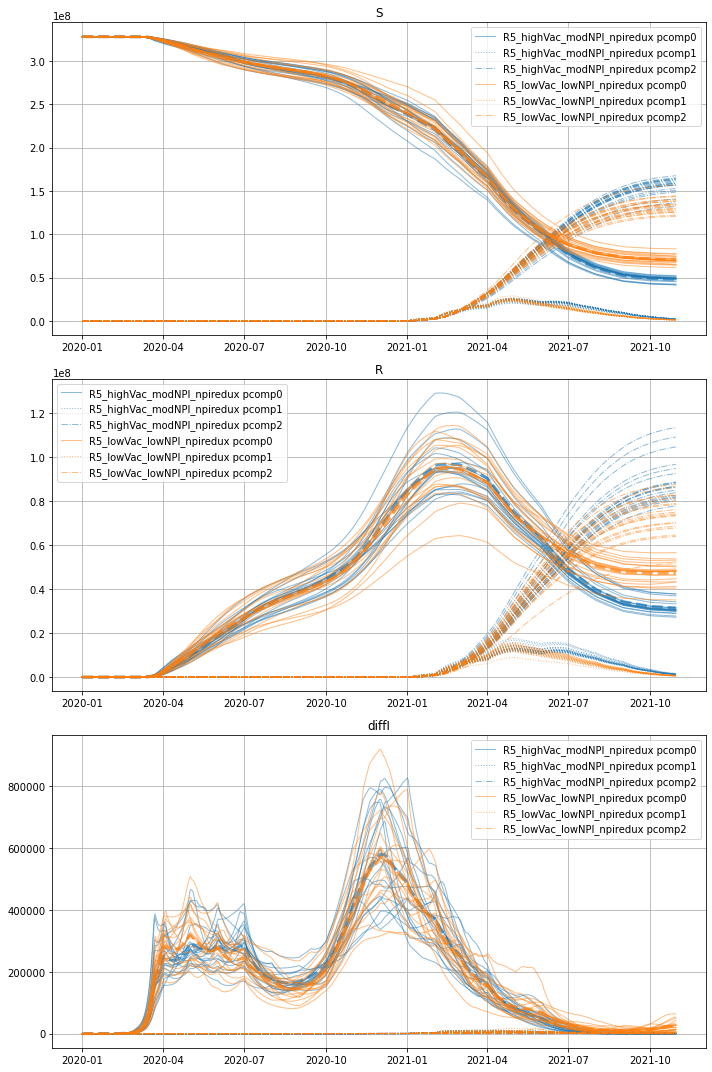

In [7]:
fig, axes = plt.subplots(3,1, figsize = (10,15))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
linestyle = ['-', ':', '-.']

comptoplot = ['S','R', 'diffI']

for k, cp in enumerate(comptoplot):
    ax = axes[k]
    i = 0
    for name, dc in all_runs.items():
        label = name
        ts_all = []
        for sim, ts in enumerate(diffIs[name]):
            ts = ts[ts['comp']==cp].drop('comp', axis=1).set_index('time').pivot(columns = 'p_comp').sum(axis=1,level=1)
            ts_all.append(ts)
            for j in ts.columns:
                ax.plot(ts[j], colors[i],  ls=linestyle[int(j)], alpha=0.5, label = label + f' pcomp{int(j)}', lw=1,) # lw = int(sim),
                pass
            label = '_'
        ax.plot(pd.concat(ts_all, axis=1).loc[:,0.0].mean(axis=1),colors[i], ls='--', alpha=0.7, label = label + f' mean', lw=3,) # lw = int(sim),
            

           # ax.set_yscale('log')
        i+=1

    ax.legend()
    ax.grid()
    ax.set_title(cp)
    #ax.set_xlim('2021-05-01','2021-11-01')
fig.tight_layout()
fig.set_facecolor('white')
#
#ax.set_ylim(0,100000)
fig.savefig('comps.pdf')

In [51]:
pd.concat(ts_all, axis=1).loc[:,0.0]

p_comp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
time,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,488.451108,5433.471680,18967.228737,6026.804205,4733.334590,3456.380438,13936.019187,2145.586689,912.696695,729.017547,2461.503230,4194.412970,1676.513662,2054.211619,12287.037482,779.055271,4633.862826,3157.790078,4909.380618,7838.034369
2021-10-27,501.102210,5525.224124,19529.429074,6161.327875,4746.428384,3492.511870,13927.119452,2171.190956,948.670238,730.461873,2486.675297,4179.324932,1625.523411,2064.289248,12113.787202,783.408438,4720.999913,3172.299997,4999.734493,8039.484282
2021-10-28,514.626791,5609.897343,20097.608582,6297.025774,4757.423547,3529.596200,13914.019141,2196.635163,986.953963,731.968689,2510.257491,4164.995016,1576.185008,2074.113678,11940.843969,788.095239,4809.908575,3187.602601,5099.517562,8241.663479


ValueError: Index contains duplicate entries, cannot reshape

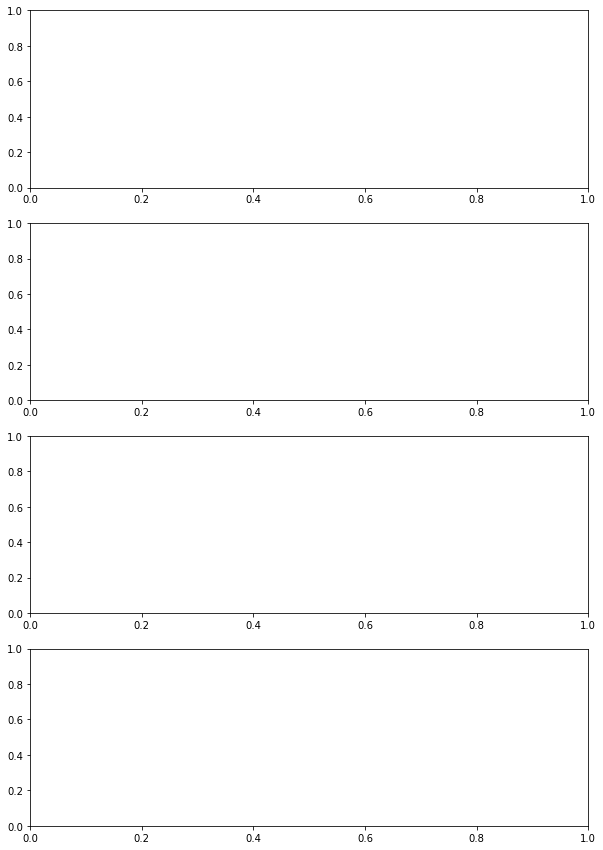

In [41]:
fig, axes = plt.subplots(4,1, figsize = (10,15))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
linestyle = ['-', ':', '-.']

comptoplot = ['S','R', 'I1', 'E']

for k, cp in enumerate(comptoplot):
    ax = axes[k]
    i = 0
    for name, dc in all_runs.items():
        label = name
        ts_all = []
        for sim, ts in enumerate(diffIs[name]):v
            ts = ts[(ts['mc_infection_stage']==cp) & (ts['value_type']=='prevalence')]
            ts = ts.drop(['value_type', 'mc_infection_stage', 'mc_name'],axis=1)
            ts = ts.set_index('date').pivot(columns = 'mc_vaccination_stage').sum(axis=1,level=1)
            ts_all.append(ts)
            for idx, cn in enumerate(ts.columns):
                ax.plot(ts[cn], colors[idx],  ls=linestyle[int(idx)], alpha=0.8, label = label + f' {cn}', lw=2,) # lw = int(sim),
                pass
            label = '_'
        #ax.plot(pd.concat(ts_all, axis=1).loc[:,0.0].mean(axis=1),colors[i], ls='--', alpha=0.7, label = label + f' mean', lw=3,) # lw = int(sim),


           # ax.set_yscale('log')
        i+=1

    ax.legend()
    ax.grid()
    ax.set_title(cp)
    #ax.set_xlim('2021-05-01','2021-11-01')
fig.tight_layout()
fig.set_facecolor('white')

<AxesSubplot:xlabel='date'>

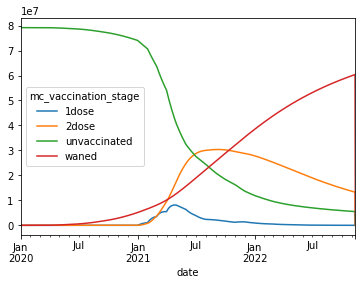

In [124]:
ts = diffIs[name][0]
#ts = ts[(ts['mc_infection_stage']==cp) & (ts['value_type']=='prevalence')]
#ts = ts.drop(['value_type', 'mc_infection_stage'],axis=1)
ts = ts[(ts['value_type']=='prevalence')]
ts = ts.drop(['value_type'],axis=1)
geoids = [i for i in ts.columns if ('mc_' not in i and i != 'date')]
ts['value'] = ts[geoids].sum(axis=1)
ts = ts.drop(geoids, axis=1)
#ts = ts.set_index('date')
mcs =  [i for i in ts.columns if ('mc_' in i)]
#ts.drop([mc for mc in mcs if mc != 'mc_vaccination_stage'], axis=1).pivot(columns='mc_vaccination_stage', values='value', index='date')
ts.groupby(['date', 'mc_vaccination_stage']).sum().reset_index().pivot(index='date', columns='mc_vaccination_stage', values='value').plot()

In [129]:
mcs

['mc_infection_stage',
 'mc_vaccination_stage',
 'mc_variant_type',
 'mc_age_strata']

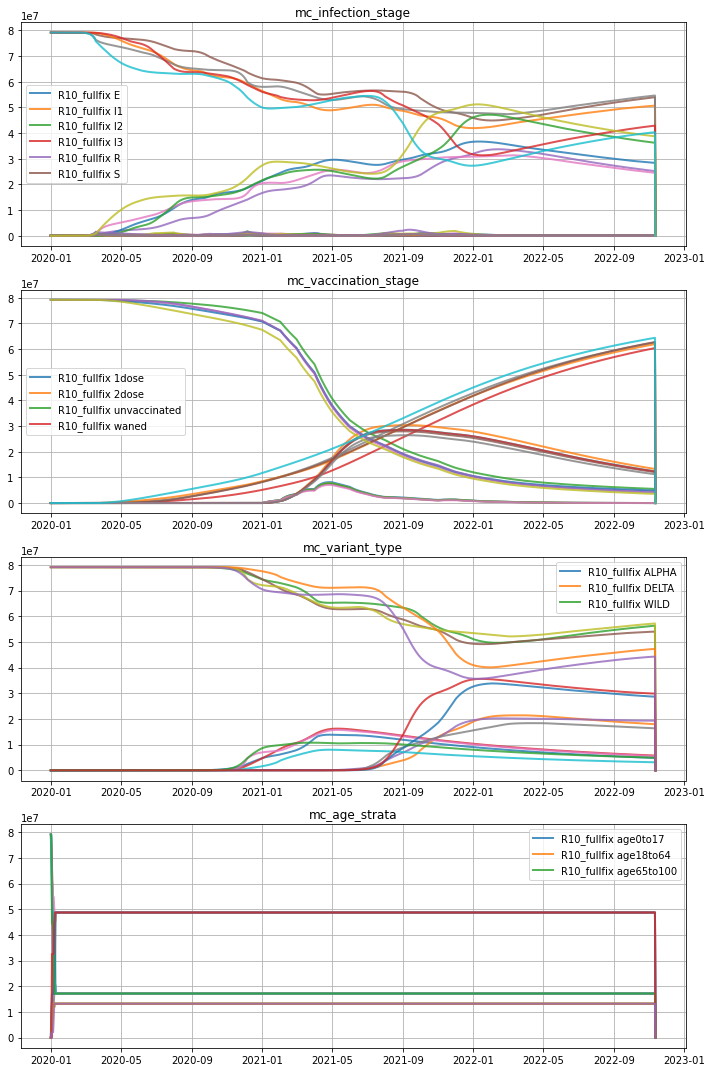

In [ ]:
colors = ['r', 'b','orange', 'green', 'yellow']
#colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
linestyle = ['-', ':', '-.', '--']

mcs =  [i for i in diffIs[name][0].columns if ('mc_' in i and 'name' not in i)]
fig, axes = plt.subplots(len(mcs),1, figsize = (10,15))

for k, mc in enumerate(mcs):
    ax = axes[k]
    i = 0
    for l, (name, dc) in enumerate(all_runs.items()):
        if l == 0:
            label = name
            ts_all = []
            for sim, ts in enumerate(diffIs[name][:5]):
                ts = ts[(ts['value_type']=='prevalence')]
                ts = ts.drop(['value_type'],axis=1)
                geoids = [i for i in ts.columns if ('mc_' not in i and i != 'date')]
                ts['value'] = ts[geoids].sum(axis=1)
                ts = ts.drop(geoids, axis=1)
                ts = ts.groupby(['date', mc]).sum().reset_index().pivot(index='date', columns=mc, values='value')
                ts_all.append(ts)
                for idx, cn in enumerate(ts.columns):
                    ax.plot(ts[cn], linestyle=linestyle[l], alpha=0.8, label = label + f' {cn}', lw=2,) # lw = int(sim),
                    pass
                label = '_'
            #ax.plot(pd.concat(ts_all, axis=1).loc[:,0.0].mean(axis=1),colors[i], ls='--', alpha=0.7, label = label + f' mean', lw=3,) # lw = int(sim),


               # ax.set_yscale('log')
            i+=1

    ax.legend()
    ax.grid()
    ax.set_title(mc)
    #ax.set_xlim('2021-05-01','2021-11-01')
fig.tight_layout()
fig.set_facecolor('white')

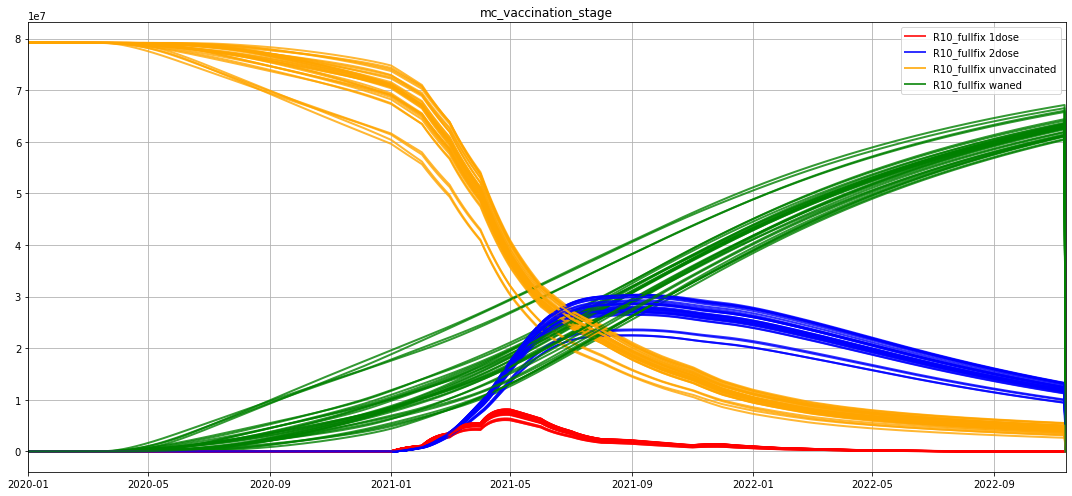

In [153]:
colors = ['r', 'b','orange', 'green', 'yellow']
#colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
linestyle = ['-', ':', '-.', '--']

mcs =  [i for i in diffIs[name][0].columns if ('mc_' in i and 'name' not in i)]
fig, axes = plt.subplots(1,1, figsize = (15,7))

for k, mc in enumerate(['mc_vaccination_stage']):
    ax = axes
    i = 0
    for l, (name, dc) in enumerate(all_runs.items()):
        if l == 0:
            label = name
            ts_all = []
            for sim, ts in enumerate(diffIs[name]):
                ts = ts[(ts['value_type']=='prevalence')]
                ts = ts.drop(['value_type'],axis=1)
                geoids = [i for i in ts.columns if ('mc_' not in i and i != 'date')]
                ts['value'] = ts[geoids].sum(axis=1)
                ts = ts.drop(geoids, axis=1)
                ts = ts.groupby(['date', mc]).sum().reset_index().pivot(index='date', columns=mc, values='value')
                ts_all.append(ts)
                for idx, cn in enumerate(ts.columns):
                    ax.plot(ts[cn], color=colors[idx], alpha=0.8, label = label + f' {cn}', lw=2,) # lw = int(sim),
                    pass
                label = '_'
            #ax.plot(pd.concat(ts_all, axis=1).loc[:,0.0].mean(axis=1),colors[i], ls='--', alpha=0.7, label = label + f' mean', lw=3,) # lw = int(sim),


               # ax.set_yscale('log')
            i+=1

    ax.legend()
    ax.grid()
    ax.set_title(mc)
    ax.set_xlim(ts.index[0],ts.index[-1])
fig.tight_layout()
fig.set_facecolor('white')

In [147]:
diffIs[name][0]

,value_type,mc_infection_stage,mc_vaccination_stage,mc_variant_type,mc_age_strata,mc_name,27000,24000,53000,12000,06000,date
0,incidence,S,unvaccinated,WILD,age0to17,S_unvaccinated_WILD_age0to17,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2020-01-01
1,incidence,S,unvaccinated,WILD,age0to17,S_unvaccinated_WILD_age0to17,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2020-01-02
2,incidence,S,unvaccinated,WILD,age0to17,S_unvaccinated_WILD_age0to17,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2020-01-03
3,incidence,S,unvaccinated,WILD,age0to17,S_unvaccinated_WILD_age0to17,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2020-01-04
4,incidence,S,unvaccinated,WILD,age0to17,S_unvaccinated_WILD_age0to17,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
452299,prevalence,R,waned,DELTA,age65to100,R_waned_DELTA_age65to100,342381.183380,331833.226249,382000.967812,1.146978e+06,1.627427e+06,2022-11-08
452300,prevalence,R,waned,DELTA,age65to100,R_waned_DELTA_age65to100,342381.420627,333476.188980,382024.148547,1.146983e+06,1.627478e+06,2022-11-09
452301,prevalence,R,waned,DELTA,age65to100,R_waned_DELTA_age65to100,342381.666967,335210.297563,382049.259879,1.146988e+06,1.627531e+06,2022-11-10
452302,prevalence,R,waned,DELTA,age65to100,R_waned_DELTA_age65to100,342381.922941,337039.297143,382076.461708,1.146994e+06,1.627585e+06,2022-11-11


# NON COMPARISON CONVERGENCE ANALYSIS

In [4]:
for name, dc in all_runs.items():

    config.clear()
    config.read(user=False)
    config.set_file(dc['config'])
    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(dc['geodata'] + spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True
    npi_df = []

    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix
    )

    folder = [x for x in Path(dc['path']).glob('**') if not x.is_file()]

    folder.reverse()

    slots_id = np.arange(1,2)

    betas = {blk:{} for blk in slots_id}

    for fold in folder:
        print(fold)
        print(f'Exploring {str(fold)[:]} ... ', end = '')
        files_loaded = 0
        for hpar_fn in tqdm(Path(str(fold)).rglob('*.parquet')):
            hpar_fn = str(hpar_fn)
            if ('chimeric' not in hpar_fn):
                #hpar =  pq.read_table(hpar_fn).to_pandas()
                #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
                #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
                #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
                #seirf = pq.read_table(hpar_fn.replace('hpar', 'seir')).to_pandas()
                slot = int(hpar_fn.split('/')[-1].split('.')[0])
                sim = hpar_fn.split('/')[-1].split('.')[1]
                if slot in slots_id and not isinstance(sim, str):
                    sim = int(sim)
                    snpi = pq.read_table(hpar_fn).to_pandas()
                    #spar = pq.read_table(hpar_fn.replace('hpar', 'spar')).to_pandas()
                    npi = NPI.NPIBase.execute(
                        npi_config=s.npi_config,
                        global_config=config,
                        geoids=s.spatset.nodenames,
                        loaded_df = snpi)
                    p_draw = setup.parameters_load(hpar_fn.replace('snpi', 'spar')[:-8],
                        'parquet',
                        len(s.t_inter),
                        s.nnodes
                    )

                    parameters = setup.parameters_reduce(p_draw, npi, s.dt)
                    betas[slot][sim] = npi.getReduction('r0').T['06000']#.mean(axis=1) #parameters[1].mean(axis = 1)

                    #reduc = snpi.set_index('npi_name').T
                    #reduc.columns = [n.lower() for n in reduc.columns]
                    #reduc = reduc.loc[['reduction','geoid']].T.reset_index()
                    #reduc['reduction'] = pd.to_numeric(reduc['reduction'])
                    #npi_df = npi_df.append(reduc)

                    files_loaded += 1

        print(files_loaded, 'files read')



2361it [00:00, 47195.52it/s]

state-runs/local_run_incomplete/snpi/USA/inference/med/mytestrun$/global/intermediate
Exploring state-runs/local_run_incomplete/snpi/USA/inference/med/mytestrun$/global/intermediate ... 0 files read


In [47]:
npi.getReduction('r0').T['06000']

2020-01-01   -0.019893
2020-01-02   -0.019893
2020-01-03   -0.019893
2020-01-04   -0.019893
2020-01-05   -0.019893
                ...   
2021-02-16    0.589713
2021-02-17    0.589713
2021-02-18    0.589713
2021-02-19    0.589713
2021-02-20    0.589713
Freq: D, Name: 06000, Length: 417, dtype: float64

In [55]:
np.arange(1,1)

array([], dtype=int64)

In [58]:
betas[blk]

{1: 2020-01-01   -1.283567
 2020-01-02   -1.283567
 2020-01-03   -1.283567
 2020-01-04   -1.283567
 2020-01-05   -1.283567
                 ...   
 2021-02-16   -0.133622
 2021-02-17   -0.133622
 2021-02-18   -0.133622
 2021-02-19   -0.133622
 2021-02-20   -0.133622
 Freq: D, Name: 06000, Length: 417, dtype: float64, 0: 2020-01-01   -0.356455
 2020-01-02   -0.356455
 2020-01-03   -0.356455
 2020-01-04   -0.356455
 2020-01-05   -0.356455
                 ...   
 2021-02-16    0.379761
 2021-02-17    0.379761
 2021-02-18    0.379761
 2021-02-19    0.379761
 2021-02-20    0.379761
 Freq: D, Name: 06000, Length: 417, dtype: float64}

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, dpi = 300)

cmap = cm.gist_heat
normalize = mcolors.Normalize(vmin=1, vmax=20)

for blk in slots_id:
    ax = axes.flat[blk-1]
    for sim, ts in betas[blk].items():
        color = cmap(normalize(int(sim)))
        ax.plot(ts,  alpha = 1, lw = 2, c=color)
        ax.set_title(f'random slot {blk}')
        ax.set_ylim(0.05, 0.4)
        ax.set_ylim(0.05, 1.2)
        ax.grid()
       # ax.set_yscale('log')
fig.tight_layout()
fig.set_facecolor('white')
s_map = cm.ScalarMappable(norm=normalize, cmap=cmap)
fig.colorbar(s_map, label = 'block')#, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g')

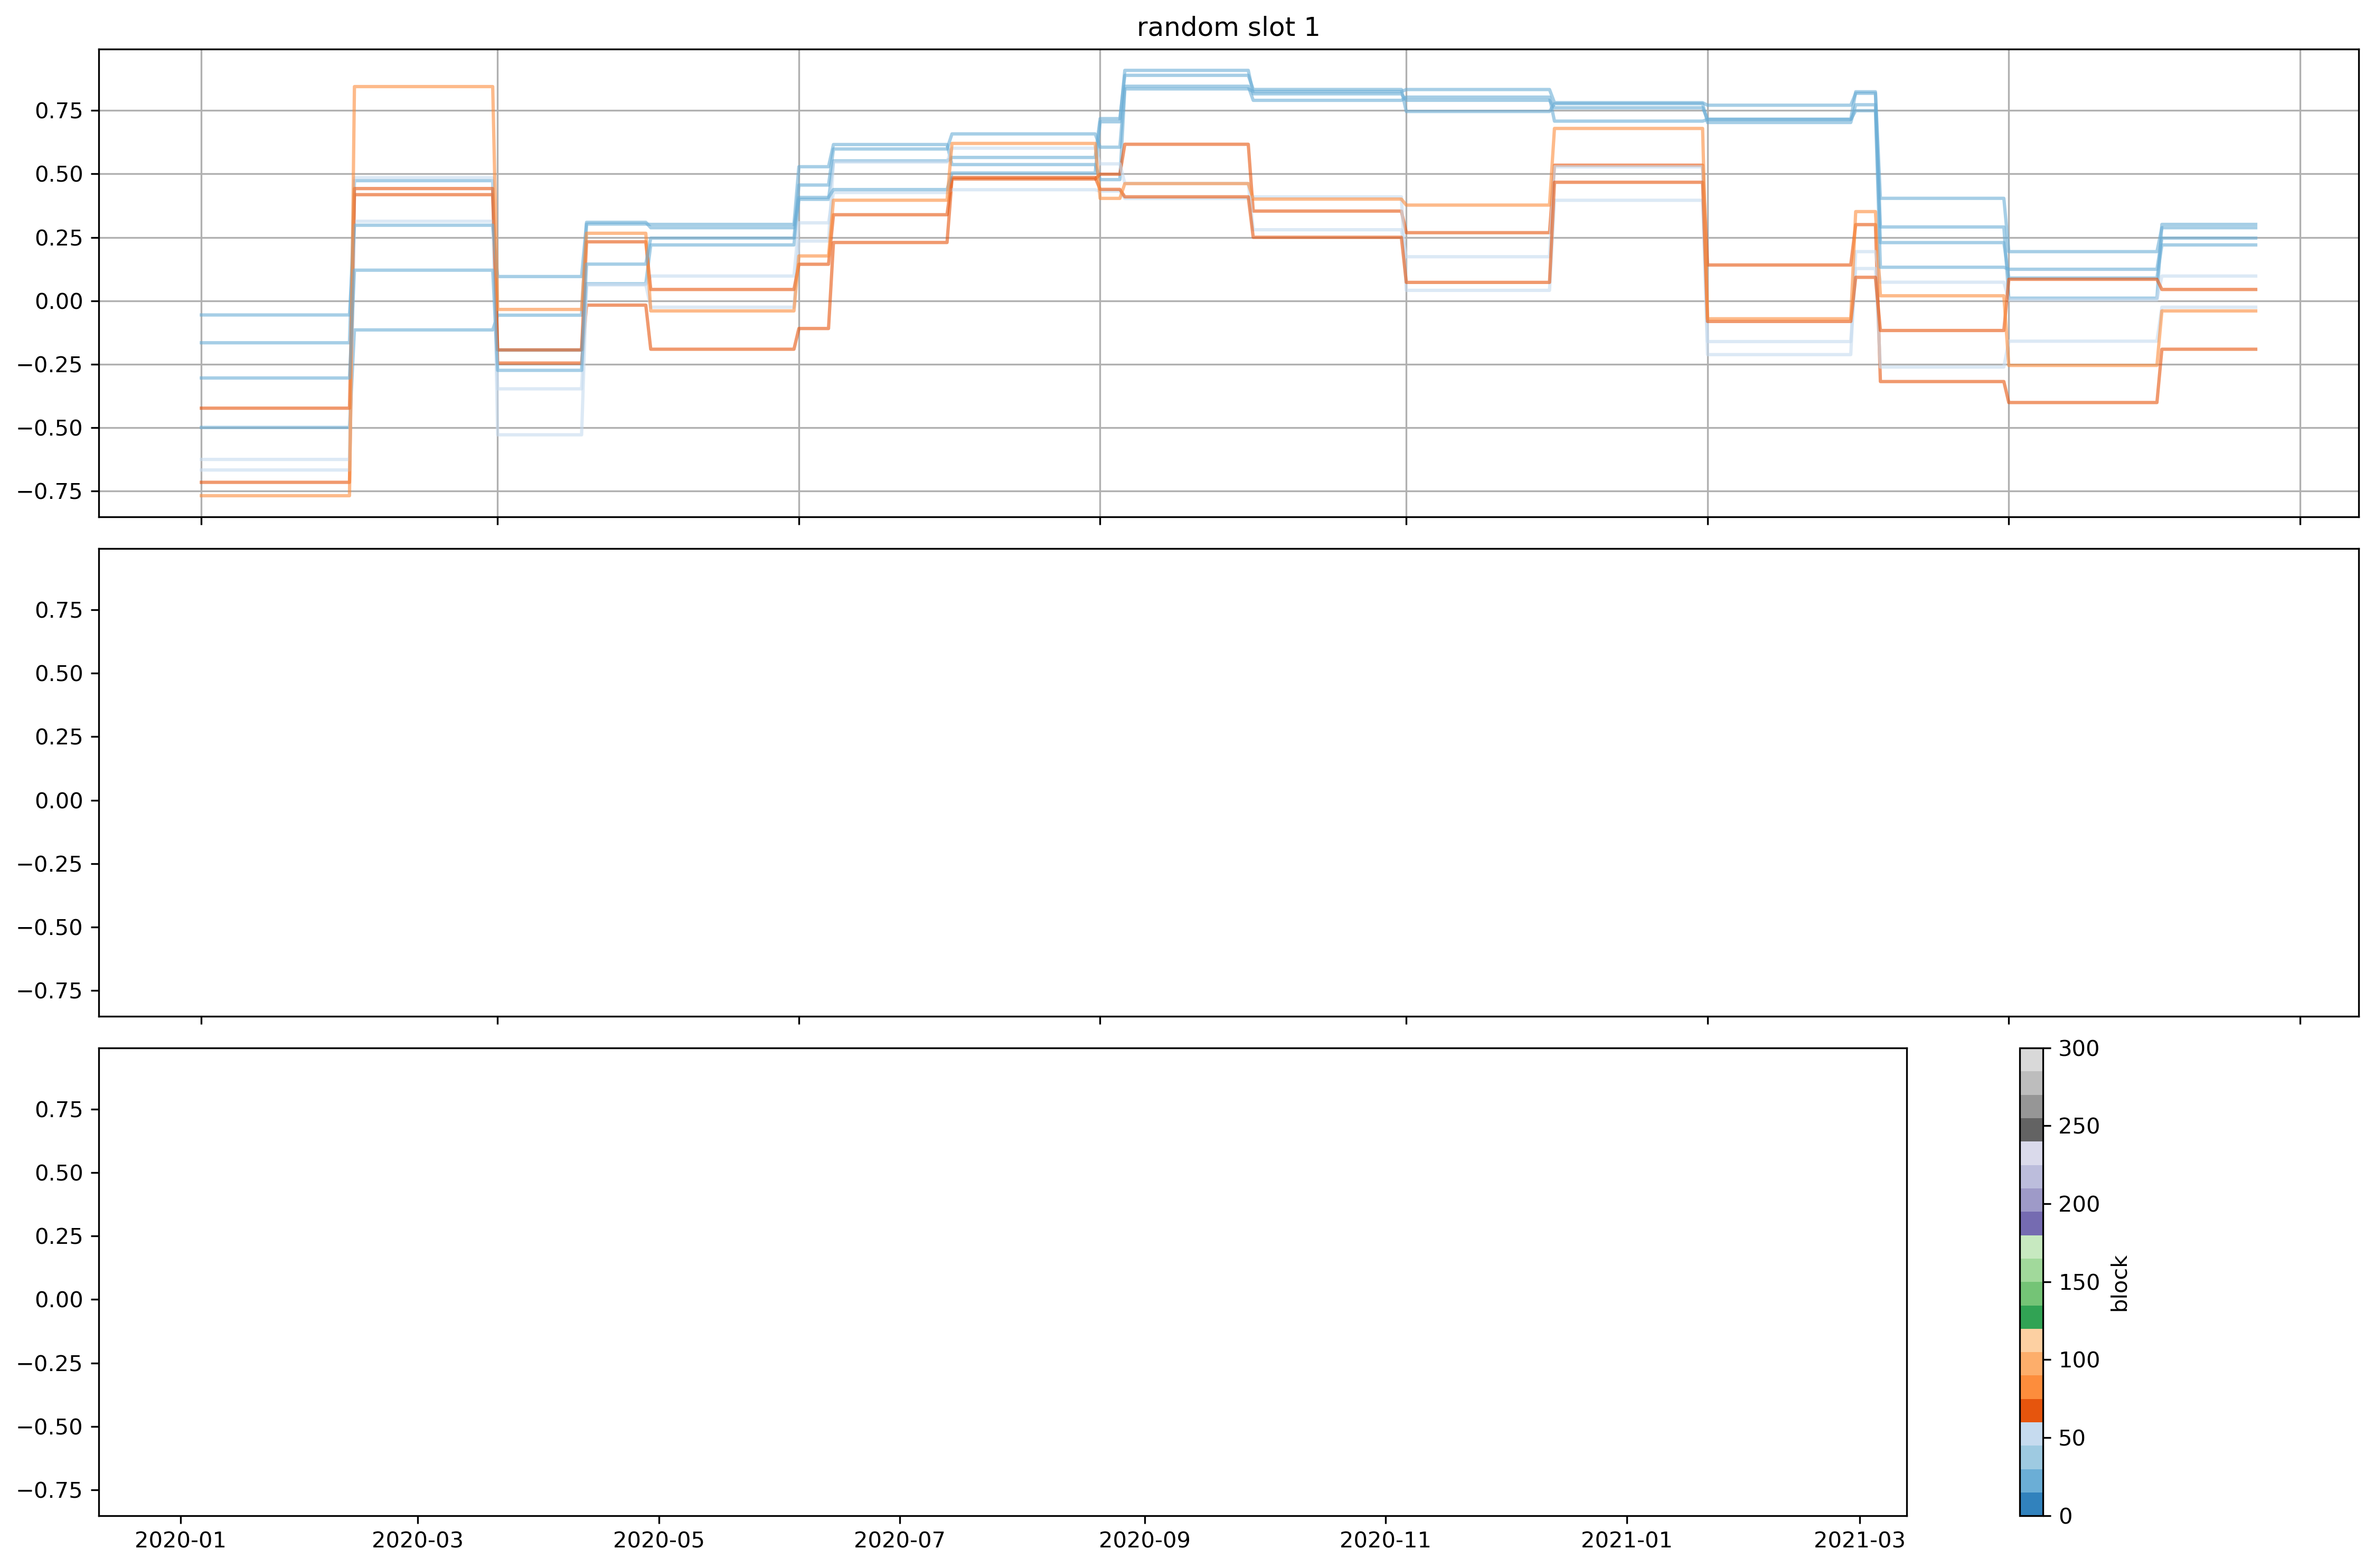

In [67]:
fig, axes = plt.subplots(3,1, figsize = (15,10), sharex = True, sharey = True, dpi = 300)

cmap = cm.gist_heat
cmap = cm.tab20c
normalize = mcolors.Normalize(vmin=0, vmax=300)

for blk in slots_id:
    ax = axes.flat[blk-1]
    for sim, ts in betas[blk].items():
        color = cmap(normalize(int(sim)))
        ax.plot(ts,   ls='-', c=color, alpha=0.6) # lw = int(sim),
        ax.set_title(f'random slot {blk}')

        ax.grid()
       # ax.set_yscale('log')
fig.tight_layout()
fig.set_facecolor('white')
s_map = cm.ScalarMappable(norm=normalize, cmap=cmap)
fig.colorbar(s_map, label = 'block')#, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g')

NameError: name 'blocks_id' is not defined

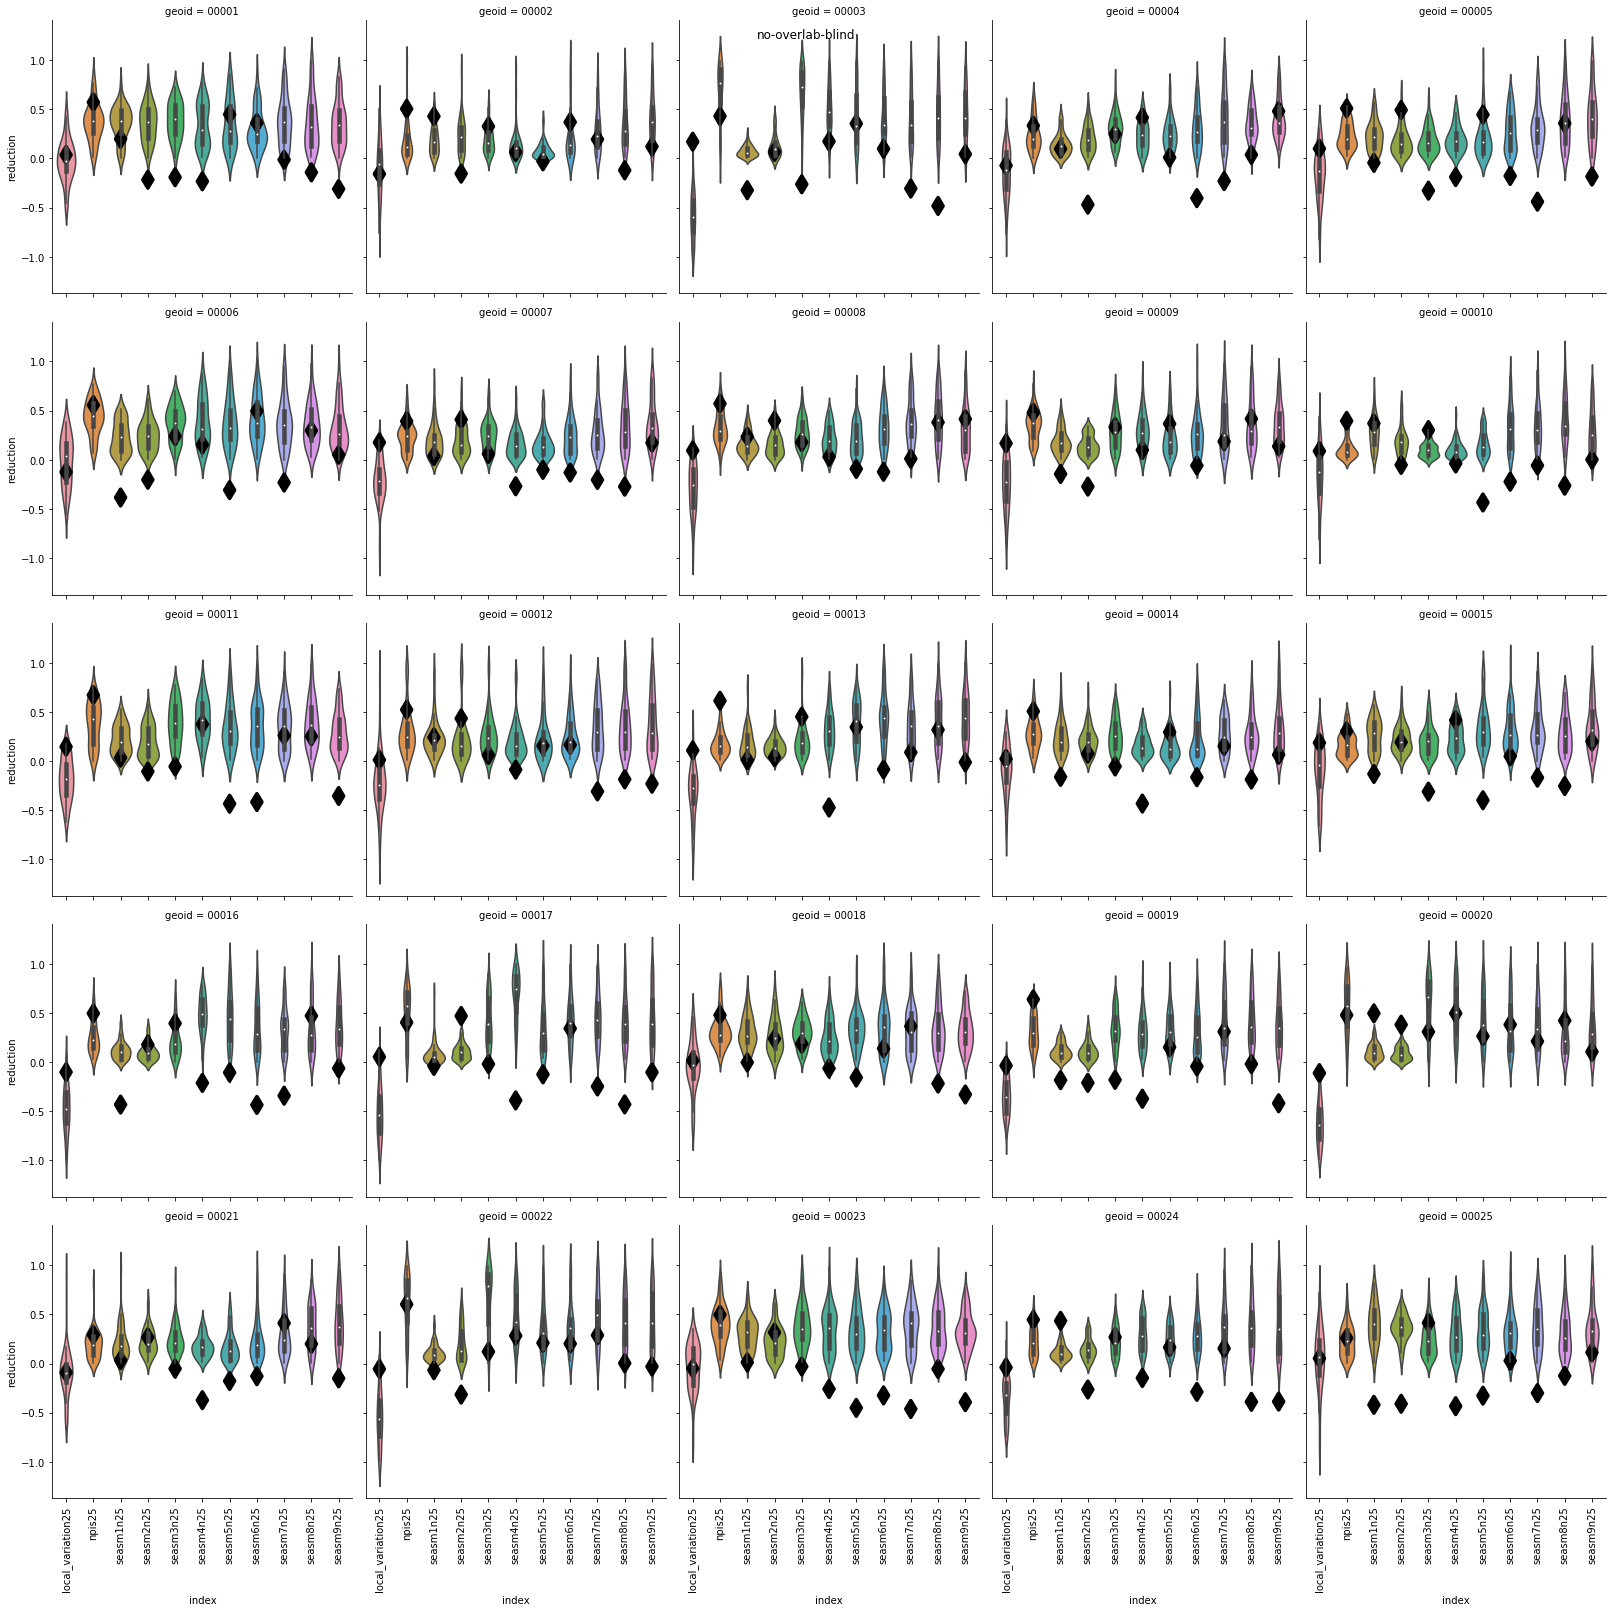

In [3]:
iris = npi_df
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)


def quantile_plot(index, reduction, **kwargs):
    sns.violinplot(x=index, y=reduction, #hue="geoid",
                   dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
              markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'index', "reduction" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [4]:
grid.savefig('npi_vals.pdf')

In [5]:
pdf.savefig(grid.fig)

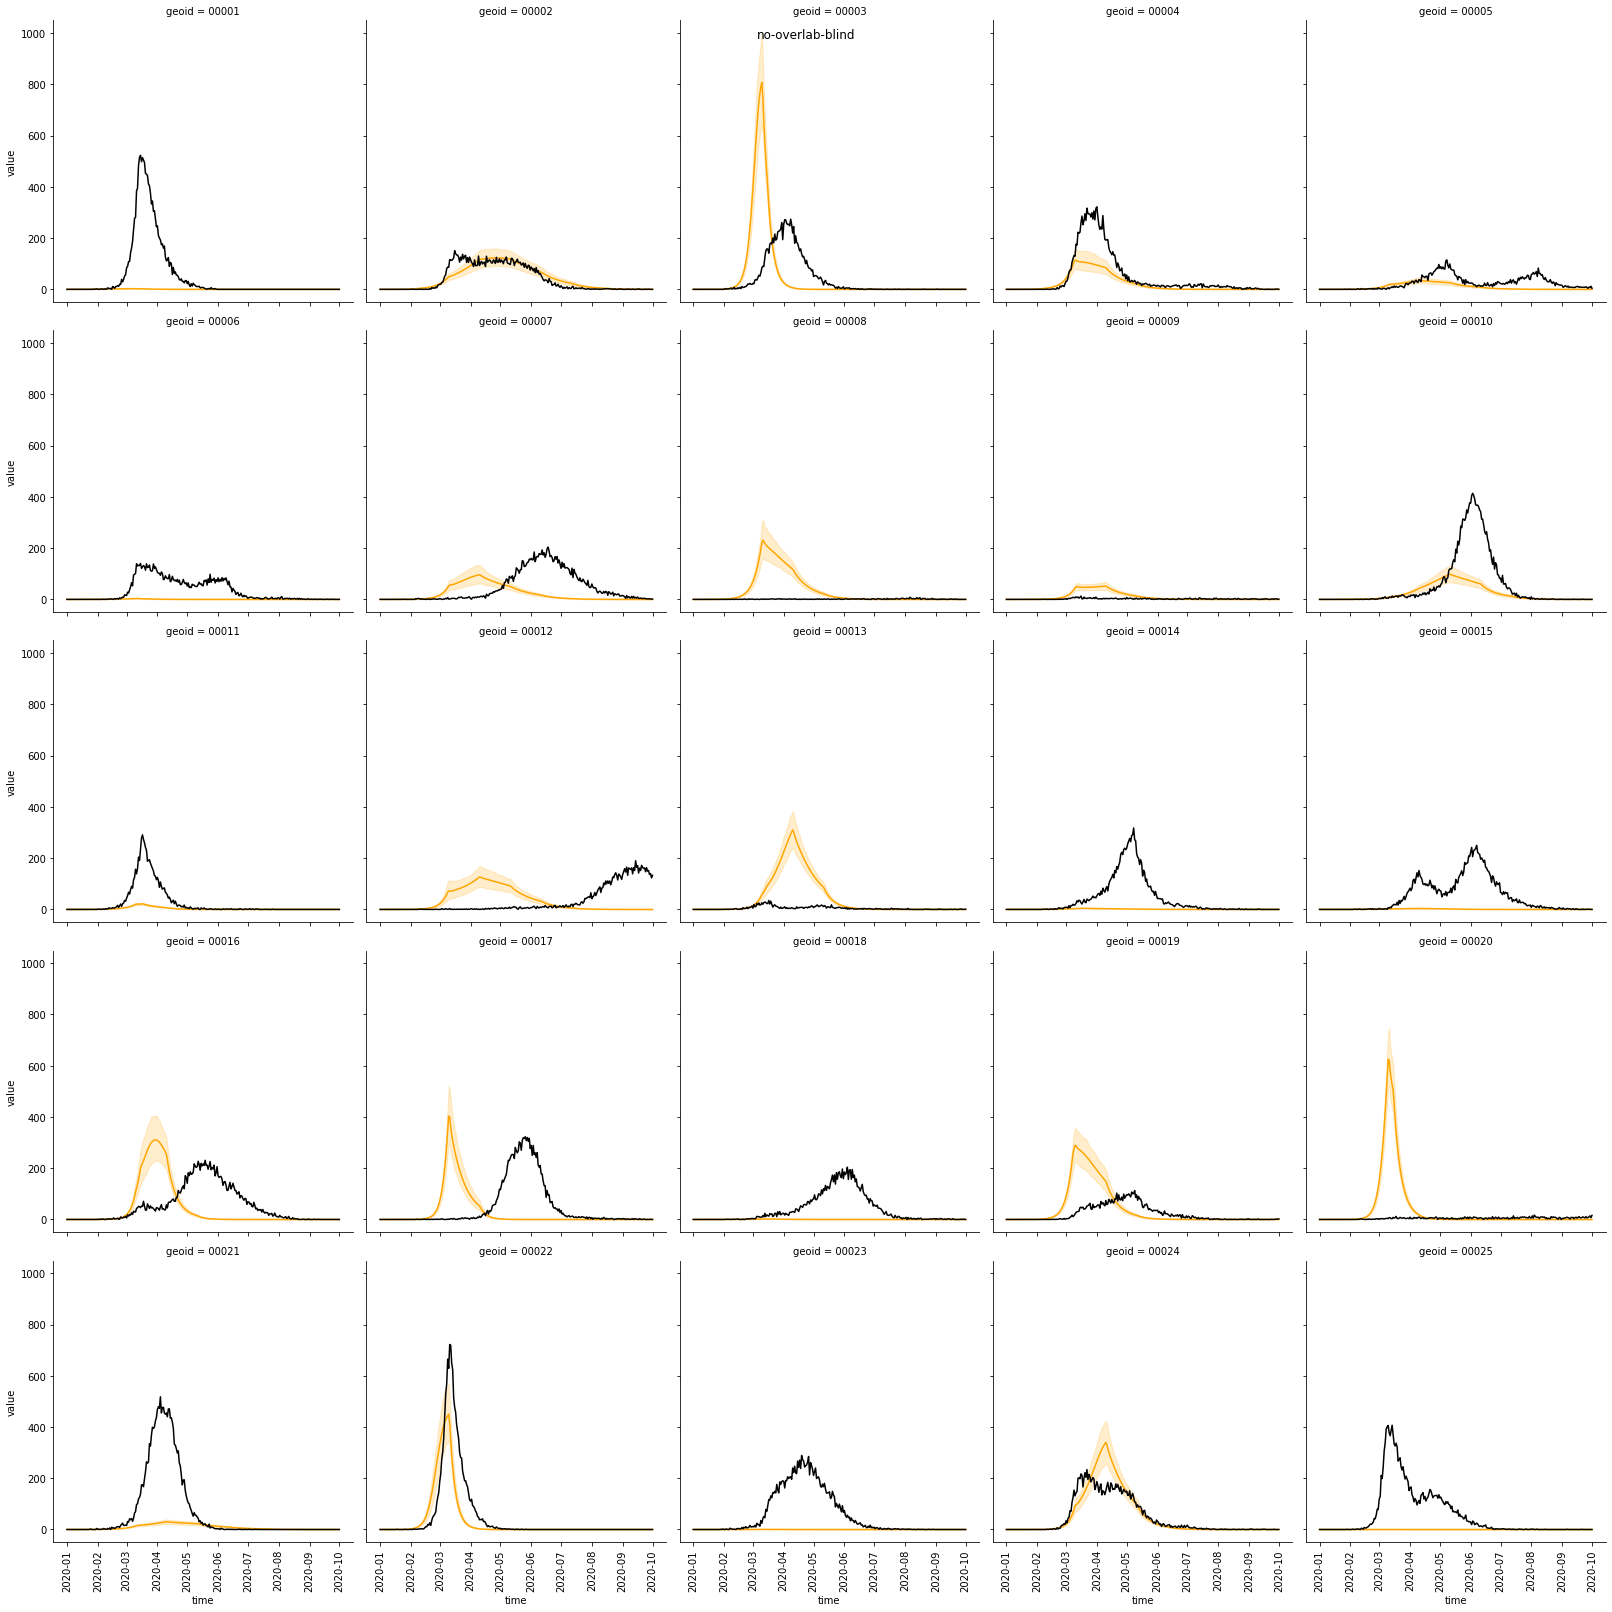

In [6]:
iris = hosp_df[hosp_df['comp']=='incidC']
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

def quantile_plot(index, reduction, **kwargs):
    sns.lineplot(x=index, y=reduction, color = 'orange',#hue="geoid",
                    zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.lineplot(x="time", y="value", data = hosp_truth[(hosp_truth['comp']=='incidC') & (hosp_truth['geoid']==kwargs['label'])],color="black")
                  #dodge=.532, join=False, #palette="dark",
             # markers="d", scale=1.75, ci=None,zorder=102, 
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'time', "value" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [7]:
pdf.savefig(grid.fig)

In [14]:
betas = np.array(betas)

In [46]:
betas = betas[:,::4,:]

In [8]:
#all_vals = np.array(all_vals)
#fig, ax = plt.subplots(7,8, figsize = (20,20), sharex = True)
#for i in range(50):
#    ax.flat[i].hist(all_vals[i::50])
#    ax.flat[i].set_title('geoid' + str(i))

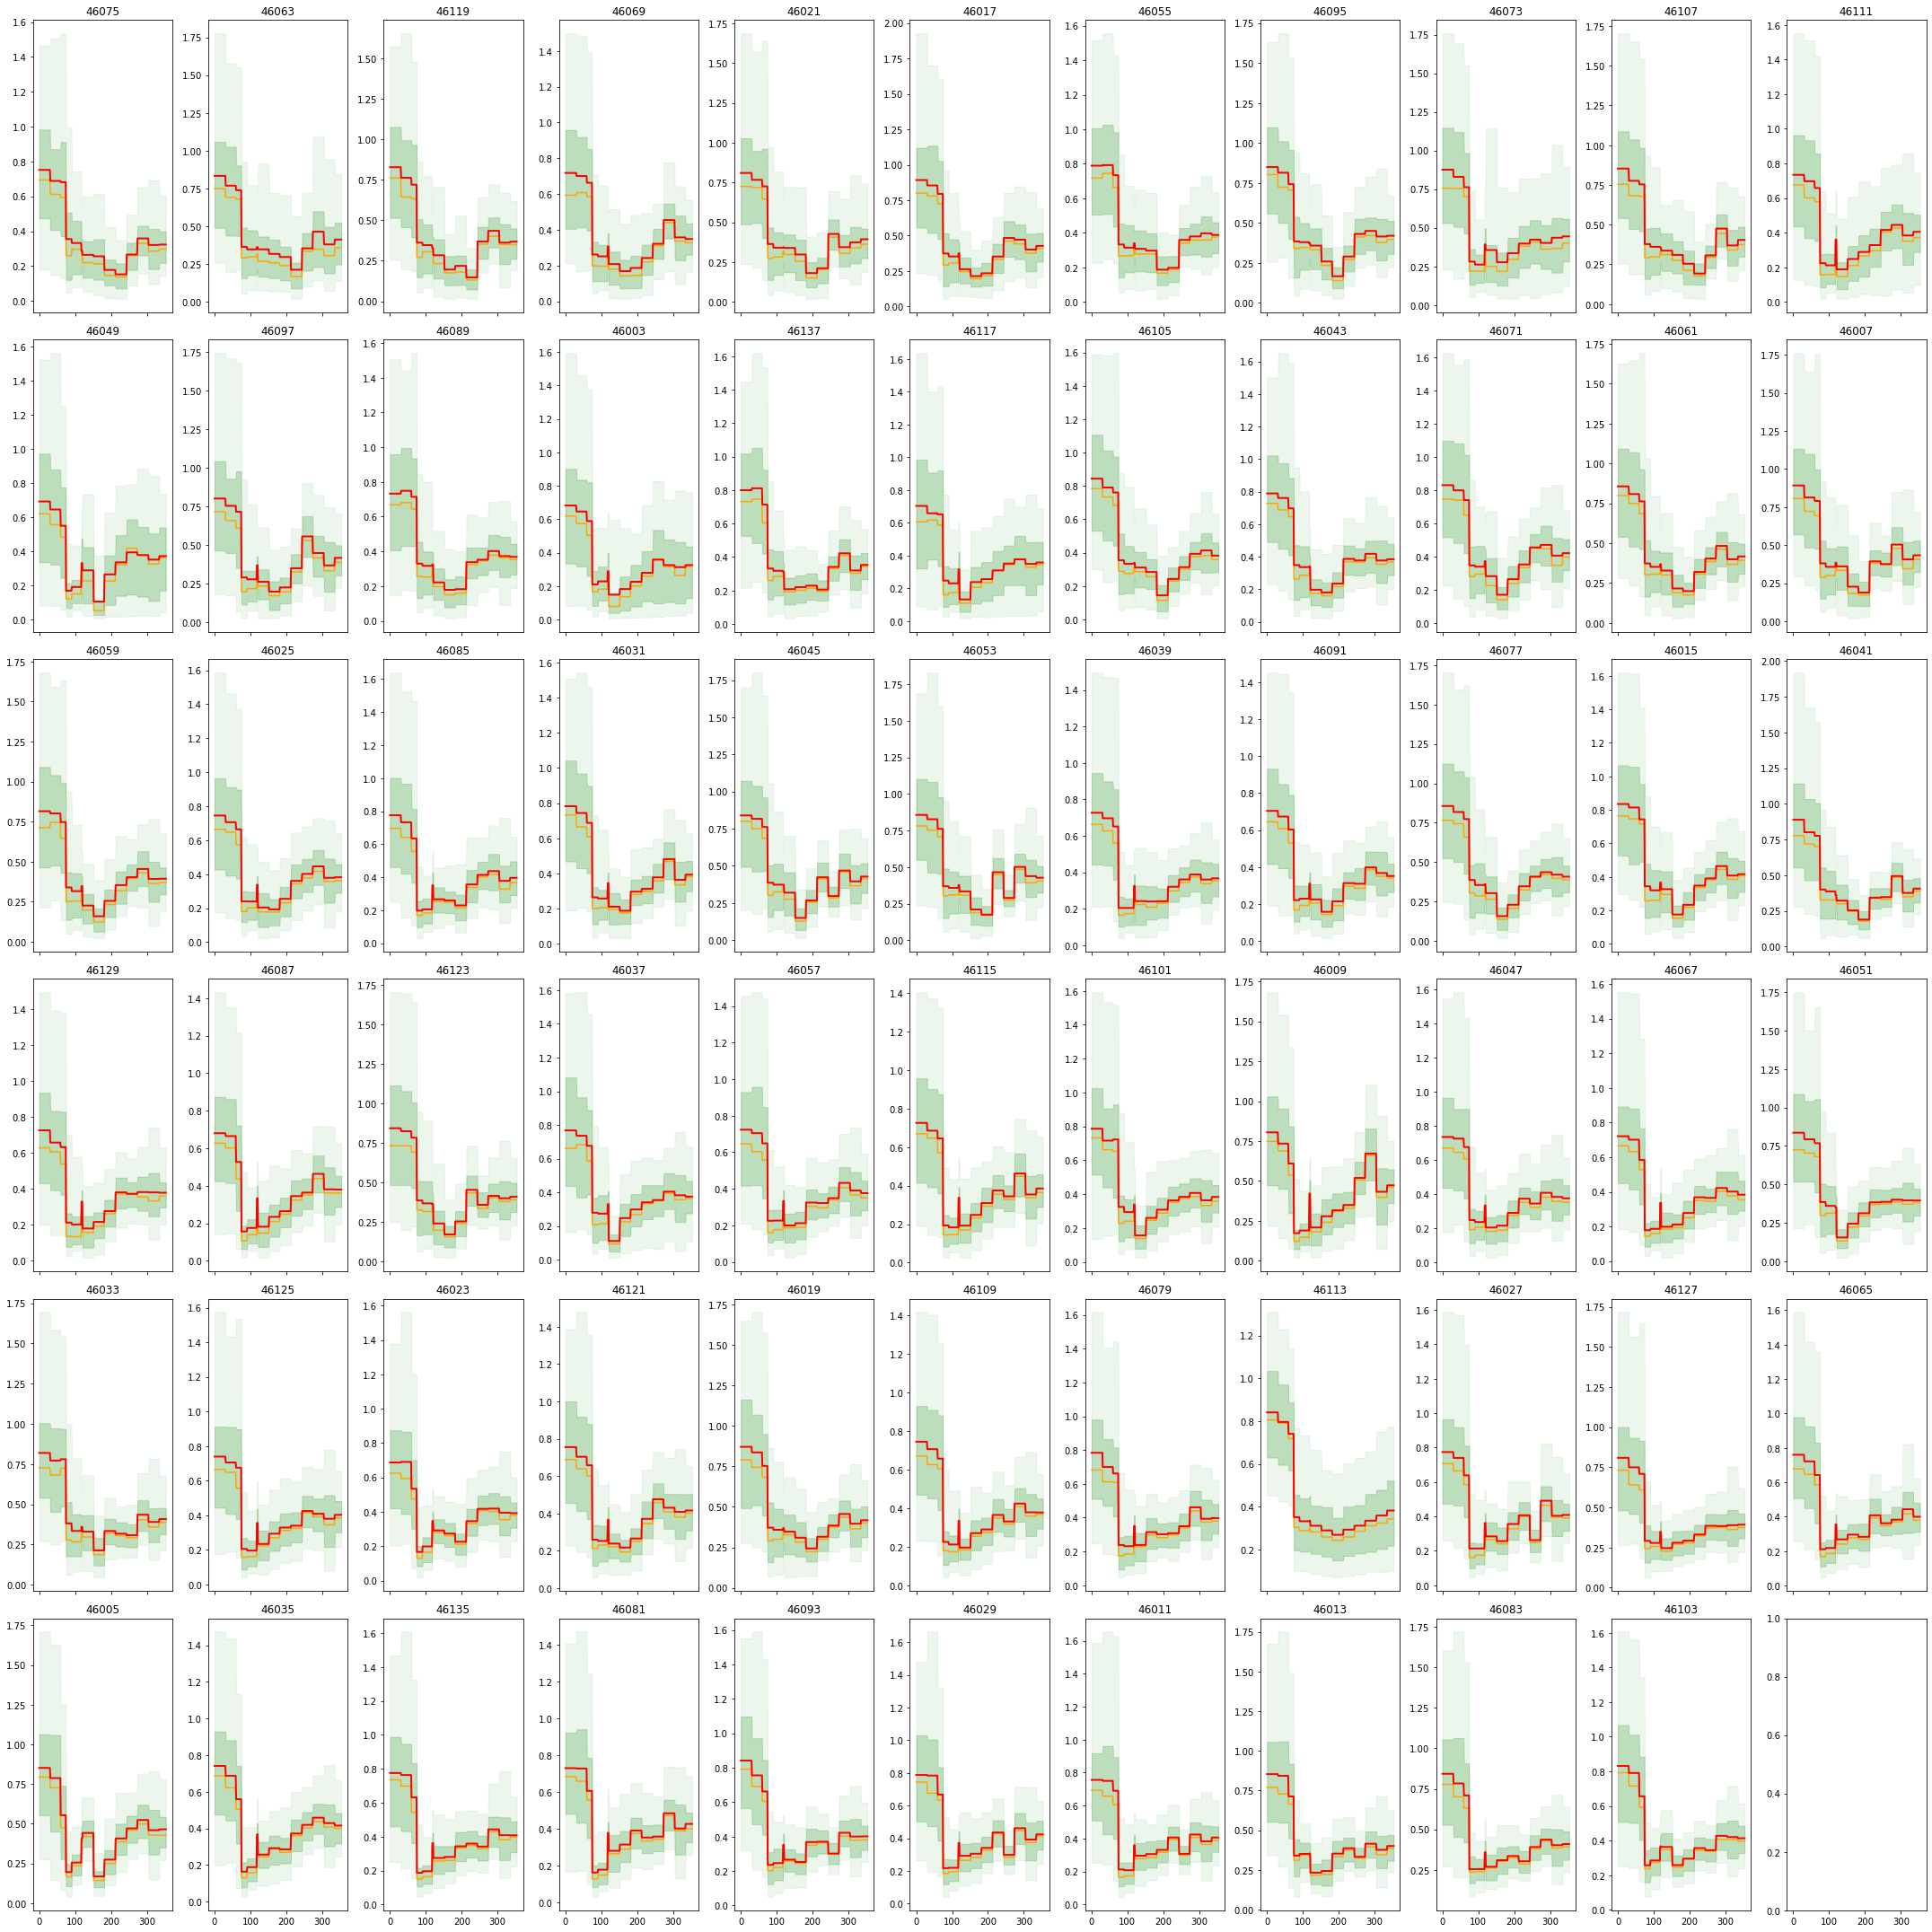

In [47]:
betas = np.array(betas)
fig, ax = plt.subplots(65//10,11, figsize = (30,30), sharex = True)
for i in range(65):
    beta = betas[:,:,i].T
    #ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.05,axis=1), np.quantile(beta,.95,axis=1), alpha = .07, color = 'g')
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.25,axis=1), np.quantile(beta,.75,axis=1), alpha = .2, color = 'g')
    ax.flat[i].plot(np.quantile(beta,.5,axis=1), color = 'orange', alpha = 1)
    ax.flat[i].plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
    #ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
    ax.flat[i].set_title(s.spatset.nodenames[i])
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

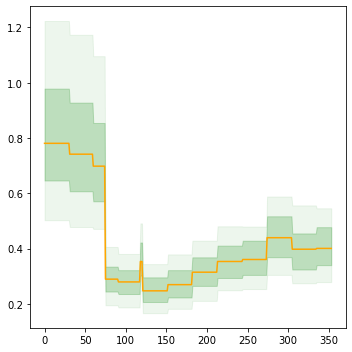

In [48]:

fig, ax = plt.subplots(1,1, figsize = (5,5), sharex = True)

all_beta = np.sum(betas, axis=2)

all_beta = np.zeros_like(betas[:,:,0])
for pl in range(betas.shape[2]):
    all_beta += betas[:,:,pl] * s.spatset.popnodes[pl]
    
all_beta /= s.spatset.popnodes.sum()
    

#ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.05,axis=0), np.quantile(all_beta,.95,axis=0), alpha = .07, color = 'g')
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.25,axis=0), np.quantile(all_beta,.75,axis=0), alpha = .2, color = 'g')
ax.plot(np.quantile(all_beta,.5,axis=0), color = 'orange', alpha = 1)
#ax.plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
#ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
#ax.flat[i].set_title('geoid' + str(i))
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

In [10]:
fig.savefig('beta_vals.pdf')

In [31]:
betas.shape

(300, 1413, 66)

In [12]:
pdf.close()

In [19]:
np.quantile(np.sumbeta,.5,axis=1).shape

(300,)

In [24]:
np.sum(betas, axis=2

(300, 1413)

In [36]:
betas.shape

(300, 1413, 66)

In [49]:
1400/4

350.0